# A Simple Bigram Language Model with PyTorch

In this notebook, we'll build a simple bigram language model using Oscar Wilde quotes. A bigram model predicts the next word given the previous word.

## What is a Bigram?

A bigram is a sequence of two consecutive words. For example:
- Sentence: "The only way to deal with an unfree world is to become absolutely free"
- Bigrams: ("The", "only"), ("only", "way"), ("way", "to"), ...

## Model Architecture

The bigram model consists of:
1. **Embedding layer**: Maps word indices to dense vectors
2. **Output layer**: Predicts logits for the next word

Given word index $i$ (the current word), the model outputs logits for all possible next words.

## Shape Tracking

- Word index (input): scalar or $(batch\_size,)$
- Embedding: $(batch\_size, embedding\_dim)$
- Output logits: $(batch\_size, vocab\_size)$
- Target (next word): $(batch\_size,)$ with integer indices
- Loss: scalar


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
import re

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

## Create One-Hot Encoded Vectors

Instead of using an embedding layer, we'll manually create one-hot encoded vectors for each word. A one-hot vector has a 1 in the position corresponding to the word and 0s elsewhere.

**One-Hot Encoding:**
- For a vocabulary of size V, each word is represented as a vector of length V
- Word at index $i$ is represented as a vector with 1 at position $i$ and 0 elsewhere
- Shape: $(vocab\_size,)$ for a single word, or $(batch\_size, vocab\_size)$ for a batch


In [2]:
# Oscar Wilde quotes
quote1 = "The only way to deal with an unfree world is to become absolutely free"
quote2 = "Be yourself; everyone else is already taken"

text = (quote1 + " " + quote2).lower()

print("=" * 70)
print("RAW TEXT")
print("=" * 70)
print(f"Quote 1: {quote1}")
print(f"Quote 2: {quote2}")
print(f"\nCombined text: {text}")

# Tokenize: split by whitespace and remove punctuation from word boundaries
# We'll treat punctuation as separate tokens
def tokenize(text):
    """Simple tokenization: split on whitespace"""
    words = text.split()
    # Remove punctuation from end of words but keep the word
    tokens = []
    for word in words:
        # Remove trailing punctuation
        word_clean = word.rstrip('.,;:!?')
        if word_clean:
            tokens.append(word_clean)
    return tokens

tokens = tokenize(text)

print("\n" + "=" * 70)
print("TOKENIZATION")
print("=" * 70)
print(f"Tokens: {tokens}")
print(f"Number of tokens: {len(tokens)}")

# Build vocabulary
vocab = sorted(set(tokens))
vocab_size = len(vocab)

print(f"\nVocabulary size: {vocab_size}")
print(f"Vocabulary: {vocab}")

# Create word-to-index and index-to-word mappings
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

print("\n" + "=" * 70)
print("WORD-TO-INDEX MAPPING")
print("=" * 70)
for word, idx in word2idx.items():
    print(f"  {word:15s} -> {idx:2d}")

RAW TEXT
Quote 1: The only way to deal with an unfree world is to become absolutely free
Quote 2: Be yourself; everyone else is already taken

Combined text: the only way to deal with an unfree world is to become absolutely free be yourself; everyone else is already taken

TOKENIZATION
Tokens: ['the', 'only', 'way', 'to', 'deal', 'with', 'an', 'unfree', 'world', 'is', 'to', 'become', 'absolutely', 'free', 'be', 'yourself', 'everyone', 'else', 'is', 'already', 'taken']
Number of tokens: 21

Vocabulary size: 19
Vocabulary: ['absolutely', 'already', 'an', 'be', 'become', 'deal', 'else', 'everyone', 'free', 'is', 'only', 'taken', 'the', 'to', 'unfree', 'way', 'with', 'world', 'yourself']

WORD-TO-INDEX MAPPING
  absolutely      ->  0
  already         ->  1
  an              ->  2
  be              ->  3
  become          ->  4
  deal            ->  5
  else            ->  6
  everyone        ->  7
  free            ->  8
  is              ->  9
  only            -> 10
  taken           ->

## Create Bigrams and Build Training Data

From the sequence of tokens, we create bigrams: each consecutive pair of words becomes a (input, target) example.

**Shape Information:**
- Input indices: $(n_{bigrams},)$ - each element is a word index
- Target indices: $(n_{bigrams},)$ - each element is the next word index
- Training pairs: Converted to PyTorch tensors for training


In [3]:
# Convert tokens to indices
token_indices = [word2idx[word] for word in tokens]

print("=" * 70)
print("TOKEN INDICES")
print("=" * 70)
print(f"Tokens:      {tokens}")
print(f"Indices:     {token_indices}")

# Create bigrams
bigrams = list(zip(token_indices[:-1], token_indices[1:]))

print("\n" + "=" * 70)
print("BIGRAMS")
print("=" * 70)
print(f"Number of bigrams: {len(bigrams)}")
print("\nBigrams (as word pairs and indices):")
for i, (input_idx, target_idx) in enumerate(bigrams):
    input_word = idx2word[input_idx]
    target_word = idx2word[target_idx]
    print(f"  {i:2d}. ({input_word:12s} -> {target_word:12s}) = ({input_idx:2d} -> {target_idx:2d})")

# Separate inputs and targets
X_indices = np.array([bg[0] for bg in bigrams])
y_indices = np.array([bg[1] for bg in bigrams])

print("\n" + "=" * 70)
print("TRAINING DATA SHAPES (INDICES)")
print("=" * 70)
print(f"X_indices shape: {X_indices.shape} - input word indices")
print(f"y_indices shape: {y_indices.shape} - target word indices")

# Create one-hot encoded vectors manually
def create_one_hot(indices, vocab_size):
    """
    Create one-hot encoded vectors from word indices.
    
    Args:
        indices: Array of shape (n_samples,) with word indices
        vocab_size: Size of vocabulary
        
    Returns:
        one_hot: Array of shape (n_samples, vocab_size) with one-hot vectors
    """
    n_samples = len(indices)
    one_hot = np.zeros((n_samples, vocab_size))
    one_hot[np.arange(n_samples), indices] = 1.0
    return one_hot

X_one_hot = create_one_hot(X_indices, vocab_size)
y_indices_tensor = torch.from_numpy(y_indices).long()

print("\n" + "=" * 70)
print("ONE-HOT ENCODED TRAINING DATA")
print("=" * 70)
print(f"X_one_hot shape: {X_one_hot.shape}")
print(f"y_indices shape: {y_indices.shape}")
print(f"\nExample one-hot encoded vectors (first 3 bigrams):")

for i in range(min(3, len(bigrams))):
    input_word = idx2word[X_indices[i]]
    target_word = idx2word[y_indices[i]]
    
    print(f"\nBigram {i+1}: '{input_word}' -> '{target_word}'")
    print(f"  Input one-hot vector (indices with 1s): {np.where(X_one_hot[i] == 1)[0]}")
    print(f"  Input one-hot: {X_one_hot[i]}")
    print(f"  Target index: {y_indices[i]}")

# Convert to PyTorch tensors
X_one_hot_tensor = torch.from_numpy(X_one_hot).float()  # (n_bigrams, vocab_size)
y_one_hot_tensor = y_indices_tensor.long()  # (n_bigrams,)

print("\n" + "=" * 70)
print("PYTORCH TENSOR SHAPES")
print("=" * 70)
print(f"X_one_hot_tensor shape: {X_one_hot_tensor.shape}, dtype: {X_one_hot_tensor.dtype}")
print(f"y_one_hot_tensor shape: {y_one_hot_tensor.shape}, dtype: {y_one_hot_tensor.dtype}")
print(f"X_one_hot_tensor:\n{X_one_hot_tensor}")
print(f"y_one_hot_tensor: {y_one_hot_tensor}")

TOKEN INDICES
Tokens:      ['the', 'only', 'way', 'to', 'deal', 'with', 'an', 'unfree', 'world', 'is', 'to', 'become', 'absolutely', 'free', 'be', 'yourself', 'everyone', 'else', 'is', 'already', 'taken']
Indices:     [12, 10, 15, 13, 5, 16, 2, 14, 17, 9, 13, 4, 0, 8, 3, 18, 7, 6, 9, 1, 11]

BIGRAMS
Number of bigrams: 20

Bigrams (as word pairs and indices):
   0. (the          -> only        ) = (12 -> 10)
   1. (only         -> way         ) = (10 -> 15)
   2. (way          -> to          ) = (15 -> 13)
   3. (to           -> deal        ) = (13 ->  5)
   4. (deal         -> with        ) = ( 5 -> 16)
   5. (with         -> an          ) = (16 ->  2)
   6. (an           -> unfree      ) = ( 2 -> 14)
   7. (unfree       -> world       ) = (14 -> 17)
   8. (world        -> is          ) = (17 ->  9)
   9. (is           -> to          ) = ( 9 -> 13)
  10. (to           -> become      ) = (13 ->  4)
  11. (become       -> absolutely  ) = ( 4 ->  0)
  12. (absolutely   -> free        ) = 

## Define the Bigram Neural Network Model (One-Hot Version)

Instead of using an embedding layer, the model takes one-hot encoded vectors as input and predicts logits for all vocabulary words.

**Architecture:**
- Input: One-hot encoded vector of shape $(vocab\_size,)$
- Linear layer: Maps from $(vocab\_size,)$ to $(vocab\_size,)$ (one-hot space to logit space)
- Output: Logits of shape $(vocab\_size,)$

This is equivalent to learning a word transition matrix where each row represents the logits for the next word given the current word.


In [4]:
class BigramModel(nn.Module):
    """
    A simple bigram language model using one-hot encoded inputs.
    
    Given a one-hot encoded word vector, predicts logits for the next word.
    
    Architecture:
    One-Hot Vector (vocab_size,) -> Linear (vocab_size, vocab_size) -> Logits (vocab_size,)
    
    This is equivalent to learning a transition matrix where element [i,j] 
    represents the logit for word j given word i.
    """
    
    def __init__(self, vocab_size):
        super(BigramModel, self).__init__()
        
        self.vocab_size = vocab_size
        
        # Linear layer: takes one-hot vector of size vocab_size, outputs logits of size vocab_size
        # Weight matrix: (vocab_size, vocab_size)
        # This is the learned transition matrix
        self.linear = nn.Linear(vocab_size, vocab_size)
    
    def forward(self, one_hot_input):
        """
        Forward pass.
        
        Args:
            one_hot_input: Tensor of shape (batch_size, vocab_size) with one-hot vectors
                          or shape (vocab_size,) if single word
            
        Returns:
            logits: Tensor of shape (batch_size, vocab_size) with output logits
                   or shape (vocab_size,) if single word
        """
        # Linear transformation
        # Input: (batch_size, vocab_size) -> Output: (batch_size, vocab_size)
        logits = self.linear(one_hot_input)
        
        return logits


# Hyperparameters
learning_rate = 0.1
n_epochs = 500

# Initialize model
model = BigramModel(vocab_size=vocab_size)

print("=" * 70)
print("BIGRAM MODEL ARCHITECTURE (ONE-HOT VERSION)")
print("=" * 70)
print(model)

print("\n" + "=" * 70)
print("MODEL PARAMETERS AND SHAPES")
print("=" * 70)
for name, param in model.named_parameters():
    print(f"{name:25s} shape: {param.shape}")

total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params}")

# Detailed parameter breakdown
print("\n" + "=" * 70)
print("PARAMETER DETAILS")
print("=" * 70)

linear_weight = model.linear.weight
linear_bias = model.linear.bias

print(f"Linear layer weights (transition matrix):")
print(f"  Shape: {linear_weight.shape} = (vocab_size, vocab_size) = ({vocab_size}, {vocab_size})")
print(f"  Total params: {linear_weight.numel()}")
print(f"  Interpretation: Weight[i,j] = logit for word j given word i")
print(f"  Initial weights (first few):\n{linear_weight.data[:3, :3]}")

print(f"\nLinear layer bias:")
print(f"  Shape: {linear_bias.shape} = ({vocab_size},)")
print(f"  Total params: {linear_bias.numel()}")
print(f"  Interpretation: Bias term added to all logits")
print(f"  Initial bias:\n{linear_bias.data}")

print(f"\n" + "=" * 70)
print("SHAPE TRANSFORMATIONS")
print("=" * 70)
print(f"\nFor a batch of size {len(X_one_hot_tensor)}:")
print(f"  One-hot input shape: {X_one_hot_tensor.shape}")
print(f"  Weight matrix shape: {linear_weight.shape}")
print(f"  Output logits shape: {X_one_hot_tensor.shape[0], vocab_size}")
print(f"\nComputation: logits = one_hot @ weight^T + bias")

BIGRAM MODEL ARCHITECTURE (ONE-HOT VERSION)
BigramModel(
  (linear): Linear(in_features=19, out_features=19, bias=True)
)

MODEL PARAMETERS AND SHAPES
linear.weight             shape: torch.Size([19, 19])
linear.bias               shape: torch.Size([19])

Total parameters: 380

PARAMETER DETAILS
Linear layer weights (transition matrix):
  Shape: torch.Size([19, 19]) = (vocab_size, vocab_size) = (19, 19)
  Total params: 361
  Interpretation: Weight[i,j] = logit for word j given word i
  Initial weights (first few):
tensor([[ 0.1754,  0.1904, -0.0537],
        [ 0.0585, -0.1057, -0.0269],
        [ 0.0251, -0.0724,  0.0616]])

Linear layer bias:
  Shape: torch.Size([19]) = (19,)
  Total params: 19
  Interpretation: Bias term added to all logits
  Initial bias:
tensor([-0.1306, -0.2068,  0.0102,  0.1017,  0.0508,  0.0454, -0.1740, -0.2142,
         0.0040,  0.2092,  0.1324, -0.1336, -0.0298, -0.1691, -0.1107,  0.0415,
         0.1249,  0.1900, -0.2106])

SHAPE TRANSFORMATIONS

For a batch

## Test Forward Pass Before Training

Let's verify the shapes before training to ensure everything works correctly.


In [ ]:
print("=" * 70)
print("TEST FORWARD PASS")
print("=" * 70)

# Test with single word
test_word_index = 0  # "the" (word at index 0)
test_word = idx2word[test_word_index]

# Create one-hot vector for this word
test_one_hot = np.zeros(vocab_size)
test_one_hot[test_word_index] = 1.0

print(f"\nTest input: word '{test_word}' with index {test_word_index}")
print(f"One-hot vector: {test_one_hot}")
print(f"Input tensor shape: ({vocab_size},)")

with torch.no_grad():
    # Single word one-hot
    input_single = torch.from_numpy(test_one_hot).float().unsqueeze(0)  # Shape: (1, vocab_size)
    logits = model(input_single)  # Shape: (1, vocab_size)
    
    print(f"Logits shape: {logits.shape}")
    print(f"Logits: {logits}")
    
    # Get probabilities
    probs = torch.softmax(logits, dim=-1)
    print(f"\nProbabilities shape: {probs.shape}")
    print(f"Sum of probabilities: {probs.sum().item():.6f}")
    
    # Get top 3 predictions
    top_probs, top_indices = torch.topk(probs, 3, dim=-1)
    print(f"\nTop 3 predictions:")
    for i, (prob, idx) in enumerate(zip(top_probs[0], top_indices[0])):
        next_word = idx2word[idx.item()]
        print(f"  {i+1}. '{next_word}' (index {idx.item()}) with probability {prob.item():.4f}")

# Test with batch
print(f"\n" + "=" * 70)
print("TEST WITH BATCH")
print("=" * 70)

batch_one_hot = X_one_hot_tensor[:3]  # First 3 training examples
print(f"\nBatch input shape: {batch_one_hot.shape}")
print(f"Input words: {[idx2word[X_indices[i]] for i in range(3)]}")

with torch.no_grad():
    batch_logits = model(batch_one_hot)
    print(f"Output logits shape: {batch_logits.shape}")
    print(f"Output logits:\n{batch_logits}")

TEST FORWARD PASS

Test input: word 'absolutely' with index 0
One-hot vector: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Input tensor shape: (19,)


## Training Loop

We'll train the bigram model using CrossEntropyLoss, which expects:
- Model output: logits of shape $(batch\_size, vocab\_size)$
- Target: integer word indices of shape $(batch\_size,)$


TRAINING CONFIGURATION
Loss function: CrossEntropyLoss
Optimizer: Adam with learning rate 0.1
Number of epochs: 500
Number of training examples (bigrams): 20

STARTING TRAINING
Epoch  50/500 | Loss: 0.171885
Epoch 100/500 | Loss: 0.153075
Epoch 150/500 | Loss: 0.147764
Epoch 200/500 | Loss: 0.145013
Epoch 250/500 | Loss: 0.143387
Epoch 300/500 | Loss: 0.142337
Epoch 350/500 | Loss: 0.141616
Epoch 400/500 | Loss: 0.141096
Epoch 450/500 | Loss: 0.140707
Epoch 500/500 | Loss: 0.140407

TRAINING COMPLETED
Final loss: 0.140407
Initial loss: 2.941630
Loss reduction: 2.801223


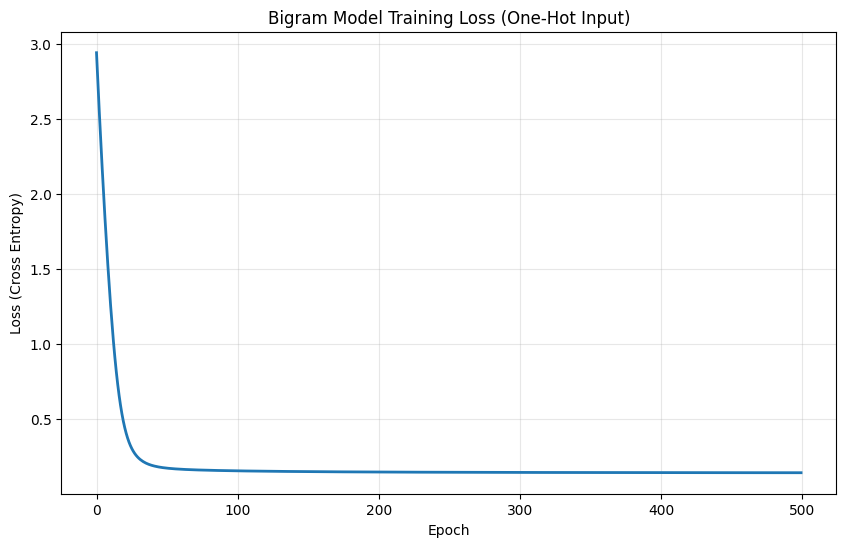

In [6]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("=" * 70)
print("TRAINING CONFIGURATION")
print("=" * 70)
print(f"Loss function: CrossEntropyLoss")
print(f"Optimizer: Adam with learning rate {learning_rate}")
print(f"Number of epochs: {n_epochs}")
print(f"Number of training examples (bigrams): {len(X_one_hot_tensor)}")

# Training loop
losses = []

print("\n" + "=" * 70)
print("STARTING TRAINING")
print("=" * 70)

for epoch in range(n_epochs):
    model.train()
    
    # Forward pass
    logits = model(X_one_hot_tensor)  # Shape: (n_bigrams, vocab_size)
    loss = criterion(logits, y_one_hot_tensor)  # Shape: scalar
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    # Print progress
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1:3d}/{n_epochs} | Loss: {loss.item():.6f}")

print("\n" + "=" * 70)
print("TRAINING COMPLETED")
print("=" * 70)
print(f"Final loss: {losses[-1]:.6f}")
print(f"Initial loss: {losses[0]:.6f}")
print(f"Loss reduction: {losses[0] - losses[-1]:.6f}")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.title('Bigram Model Training Loss (One-Hot Input)')
plt.grid(True, alpha=0.3)
plt.show()

## Evaluate Trained Model

Now let's use the trained model to predict the next word given a current word.


In [8]:
# Set model to evaluation mode
model.eval()

# Get predictions for all training bigrams
with torch.no_grad():
    logits_all = model(X_one_hot_tensor)  # Shape: (n_bigrams, vocab_size)
    predictions = torch.argmax(logits_all, dim=-1)  # Shape: (n_bigrams,)
    probs_all = torch.softmax(logits_all, dim=-1)  # Shape: (n_bigrams, vocab_size)

# Calculate accuracy
accuracy = (predictions == y_one_hot_tensor).float().mean().item()

print("=" * 70)
print("MODEL EVALUATION ON TRAINING DATA")
print("=" * 70)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Show detailed predictions
print("\n" + "=" * 70)
print("DETAILED PREDICTIONS")
print("=" * 70)

for i, (input_idx, target_idx) in enumerate(bigrams):
    input_word = idx2word[input_idx]
    target_word = idx2word[target_idx]
    pred_idx = predictions[i].item()
    pred_word = idx2word[pred_idx]
    pred_prob = probs_all[i, pred_idx].item()
    target_prob = probs_all[i, target_idx].item()
    
    correct = "✓" if pred_idx == target_idx else "✗"
    
    print(f"\n{i+1}. Input: '{input_word}' -> True next: '{target_word}'")
    print(f"   Predicted: '{pred_word}' (probability: {pred_prob:.4f}) {correct}")
    print(f"   True word probability: {target_prob:.4f}")
    
    # Show top 3 predictions
    top_probs, top_indices = torch.topk(probs_all[i], 3)
    print(f"   Top 3 predictions:")
    for rank, (prob, idx) in enumerate(zip(top_probs, top_indices)):
        word = idx2word[idx.item()]
        print(f"      {rank+1}. '{word}' ({prob.item():.4f})")

MODEL EVALUATION ON TRAINING DATA
Accuracy: 0.9000 (90.00%)

DETAILED PREDICTIONS

1. Input: 'the' -> True next: 'only'
   Predicted: 'only' (probability: 0.9982) ✓
   True word probability: 0.9982
   Top 3 predictions:
      1. 'only' (0.9982)
      2. 'to' (0.0002)
      3. 'is' (0.0002)

2. Input: 'only' -> True next: 'way'
   Predicted: 'way' (probability: 0.9981) ✓
   True word probability: 0.9981
   Top 3 predictions:
      1. 'way' (0.9981)
      2. 'is' (0.0002)
      3. 'to' (0.0001)

3. Input: 'way' -> True next: 'to'
   Predicted: 'to' (probability: 0.9984) ✓
   True word probability: 0.9984
   Top 3 predictions:
      1. 'to' (0.9984)
      2. 'is' (0.0002)
      3. 'deal' (0.0001)

4. Input: 'to' -> True next: 'deal'
   Predicted: 'become' (probability: 0.4992) ✗
   True word probability: 0.4992
   Top 3 predictions:
      1. 'become' (0.4992)
      2. 'deal' (0.4992)
      3. 'is' (0.0002)

5. Input: 'deal' -> True next: 'with'
   Predicted: 'with' (probability: 0.9981) ✓

## Generate Text Using the Model

Let's generate new text by starting with a word and repeatedly predicting the next word.


In [ ]:
def generate_text(model, idx2word, word2idx, start_word, max_length=10):
    """
    Generate text using the bigram model.
    
    Args:
        model: The trained bigram model
        idx2word: Index to word mapping
        word2idx: Word to index mapping
        start_word: Starting word for generation
        max_length: Maximum number of words to generate
        
    Returns:
        Generated text as a string
    """
    model.eval()
    
    generated_words = [start_word]
    current_word = start_word
    
    with torch.no_grad():
        for _ in range(max_length - 1):
            # Get current word index
            current_idx = word2idx[current_word]
            
            # Create one-hot vector
            one_hot = np.zeros(len(word2idx))
            one_hot[current_idx] = 1.0
            one_hot_tensor = torch.from_numpy(one_hot).float().unsqueeze(0)
            
            # Get logits for next word
            logits = model(one_hot_tensor)  # Shape: (1, vocab_size)
            
            # Get probabilities
            probs = torch.softmax(logits, dim=-1)  # Shape: (1, vocab_size)
            
            # Sample or take argmax
            next_idx = torch.argmax(probs, dim=-1).item()
            next_word = idx2word[next_idx]
            
            generated_words.append(next_word)
            current_word = next_word
    
    return " ".join(generated_words)

# Generate text starting from different words
print("=" * 70)
print("TEXT GENERATION")
print("=" * 70)

start_words = ["the", "be", "yourself", "world"]

for start_word in start_words:
    if start_word in word2idx:
        generated = generate_text(model, idx2word, word2idx, start_word, max_length=8)
        print(f"\nStarting with '{start_word}':")
        print(f"  Generated: {generated}")
    else:
        print(f"\nWord '{start_word}' not in vocabulary")

## Inspect Learned Embeddings

Let's examine the embedding vectors learned for each word to see if similar words have similar embeddings.


In [ ]:
print("=" * 70)
print("LEARNED TRANSITION MATRIX")
print("=" * 70)

# Get the learned weight matrix (this is the transition matrix)
transition_matrix = model.linear.weight.detach().numpy()  # Shape: (vocab_size, vocab_size)
bias = model.linear.bias.detach().numpy()  # Shape: (vocab_size,)

print(f"\nTransition matrix shape: {transition_matrix.shape}")
print(f"Interpretation:")
print(f"  Rows represent input words (current word)")
print(f"  Columns represent output words (next word)")
print(f"  Element [i,j] = logit for word j given word i")

print(f"\nTransition matrix:")
print(f"{'Word':15s}", end="")
for col_word in vocab:
    print(f"{col_word:8s}", end="")
print()
print("-" * (15 + 8 * len(vocab)))

for i, row_word in enumerate(vocab):
    print(f"{row_word:15s}", end="")
    for j in range(len(vocab)):
        logit = transition_matrix[i, j]
        # Convert logit to probability for readability
        all_logits = transition_matrix[i, :]
        prob = np.exp(logit) / np.sum(np.exp(all_logits))
        print(f"{prob:8.4f}", end="")
    print()

print(f"\nBias term:")
for i, word in enumerate(vocab):
    print(f"  {word:15s}: {bias[i]:.6f}")

# Analyze what the model learned
print("\n" + "=" * 70)
print("MODEL PREDICTIONS ANALYSIS")
print("=" * 70)

print("\nMost likely next word for each word:")
for i, word in enumerate(vocab):
    # Get the row for this word
    logits = transition_matrix[i, :] + bias
    
    # Convert to probabilities
    probs = np.exp(logits) / np.sum(np.exp(logits))
    
    # Get top 3
    top_indices = np.argsort(probs)[-3:][::-1]
    
    print(f"\n  Given '{word}':")
    for rank, idx in enumerate(top_indices, 1):
        next_word = vocab[idx]
        prob = probs[idx]
        print(f"    {rank}. '{next_word}' ({prob:.4f})")

## Summary: One-Hot Bigram Model Architecture

### Model Flow

$$
\text{Word Index} \xrightarrow{\text{One-Hot}}  \text{One-Hot Vector} \xrightarrow{\text{Linear}(V, V)} \text{Logits}
$$

where $V$ is the vocabulary size.

### Shape Transformations

For a batch of $B$ words:

| Component | Shape | Description |
|-----------|-------|-------------|
| Input (word indices) | $(B,)$ | B word indices |
| One-hot encoded | $(B, V)$ | B one-hot vectors of size V |
| Output logits | $(B, V)$ | Logits for next word prediction |
| Softmax (probabilities) | $(B, V)$ | Probability distribution over vocabulary |
| Predictions (argmax) | $(B,)$ | Predicted next word indices |

### Model Parameters

For a bigram model with vocabulary size $V$:

$$
\text{Total parameters} = \underbrace{V \times V}_{\text{Linear weight}} + \underbrace{V}_{\text{Linear bias}} = V(V + 1)
$$

### Key Difference from Embedding Version

**Embedding Layer Approach:**
- Word index → Dense embedding vector $(embedding\_dim,)$ → Logits
- More compact representation, embeddings can capture semantic similarity
- Total parameters: $V \times embedding\_dim + embedding\_dim \times V + V$

**One-Hot Approach:**
- Word index → One-hot vector $(V,)$ → Logits
- Full-rank representation, direct access to all information
- Total parameters: $V \times V + V$
- Weight matrix is a learned transition matrix

### Interpretation: Transition Matrix

The learned weight matrix is a **transition matrix** where:
- Row $i$ represents logits for all possible next words given word $i$
- Element $[i,j]$ represents the learned likelihood of word $j$ following word $i$
- After softmax, this gives probability distribution over next words

### Advantages and Disadvantages

**One-Hot Approach:**
- ✓ Simple and interpretable - direct word-to-word relationships
- ✓ Full-rank representation preserves all information
- ✗ More parameters for large vocabularies ($V^2$ vs $V \times embedding\_dim$)
- ✗ No learned semantic similarity - each word is orthogonal

**Embedding Approach:**
- ✓ Fewer parameters for large vocabularies
- ✓ Can capture semantic relationships between words
- ✗ Less interpretable - embeddings are abstract
- ✗ May lose information when embedding dimension is too small

### Mathematical Formulation

For input one-hot vector $\mathbf{e}_i$ (1 at position $i$, 0 elsewhere):

$$
\text{logits} = \mathbf{e}_i^T W + \mathbf{b}
$$

where $W \in \mathbb{R}^{V \times V}$ is the transition matrix and $\mathbf{b} \in \mathbb{R}^V$ is the bias term.

This is equivalent to:
$$
\text{logits} = W[i, :] + \mathbf{b}
$$

i.e., selecting row $i$ from the weight matrix.

### Real-World Applications

This simple one-hot bigram model demonstrates:
1. **Language modeling fundamentals**: Predicting next words from context
2. **Matrix interpretation**: Weight matrix as learned relationships
3. **One-hot encoding**: Basic representation for categorical variables
4. **Extension to n-grams**: Can be extended to longer contexts by concatenating one-hot vectors
5. **Building blocks**: Foundation for more complex sequence models (RNNs, Transformers)
